In [16]:
training_set_size = 30
num_particles = 50
BATCH_SIZE = 512
IMAGE_SIZE = 64
NUMBER_OF_PARTICLES = 0.0 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 20
NEW_MODELS=1
save_model_path = "/content/drive/My Drive/imag_n_real_feb22/"
models_path = "/content/drive/My Drive/imag_n_real_feb21/"

In [17]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==1.0.1
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

Mon Mar 21 13:24:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W /  70W |   1080MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
"""Import the validation set"""
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

drive.mount('/content/drive')
filePath = "/content/drive/My Drive/valset/valset_1.mat"

data = mat73.loadmat(filePath)
data = data['CompletedTraces']

shape = [64, 64]
realM = np.zeros((len(data), 64, 64, 1))
imagM = 1j * np.ones((len(data), 64, 64, 1))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


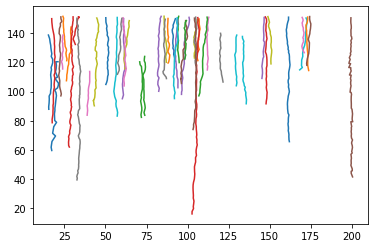

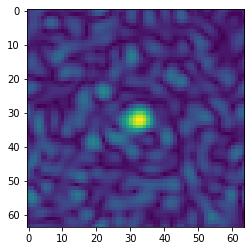

training images shape (30, 64, 64, 2)
validation images shape (34, 64, 64, 1)


In [19]:
"""Saves images and positions for individual particles."""
particles_timeseries = []
particles_positions = []

for i in range(num_particles):
    frames = data[i]["Positions"][:,0].astype(int)
    positions = data[i]["Positions"][:,1:4]
    particles_positions.append(positions)

    roi_data = np.array(data[i]['ROI'][0])
    timeseries = []
    for j in range(roi_data.shape[0]):
        particleROI = np.fft.ifft2(exp_expand(roi_data[j,:], shape))
        particleROI = np.fft.fftshift(particleROI)
        particleROI = np.expand_dims(particleROI, axis = -1)
        timeseries.append(particleROI)
    particles_timeseries.append(np.array(timeseries))

for particle_id in range(num_particles):
    plt.plot(particles_positions[particle_id][:,0], particles_positions[particle_id][:,1])
plt.show()

for _ in range(1):
    plt.imshow(np.abs(particles_timeseries[0][_,:,:,0]))
    plt.show()

particle_id = 10

training_images = np.stack((np.real(particles_timeseries[particle_id])[:training_set_size,:,:,0], np.imag(particles_timeseries[particle_id][:training_set_size,:,:,0])), axis=-1)
print(f"training images shape {training_images.shape}")
validation_set = particles_timeseries[particle_id][training_set_size:,:,:,:]
print(f"validation images shape {validation_set.shape}")

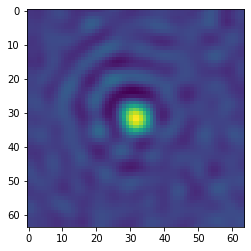

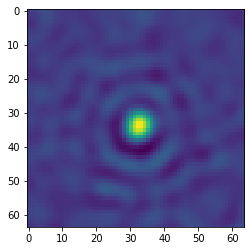

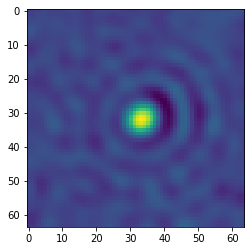

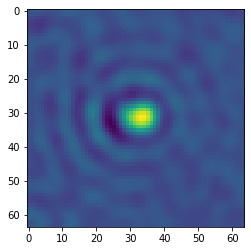

In [20]:
"""Create group/equivariance"""

crop_size = 64
padding = 32
wavelength = 525e-9
pixel_size = 114e-9 #??
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

args = dt.Arguments(
    translate=lambda: np.random.randn(2)*1,
    rotate=lambda: np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randn(1),
)

group = ( 
    dt.Affine(rotate=args.rotate) 
    >> dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.00)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Equivariance(-1, args.z, indexes=2)
)

import random
training_set = dt.Value(lambda: random.choice(training_images)) 

for _ in range(4):
    x = (training_set>>group).update()()
    plt.imshow(x[..., 1])
    plt.show()


In [21]:
"""Create custom layers"""
from tensorflow.math import abs, angle, real, imag, subtract, multiply

class CustomLayerOne(keras.layers.Layer):
    "Dpes nothing"
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), angle(image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerTwo(keras.layers.Layer):
    "Takes 2 layers as input and outputs 3 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), abs(norm_image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerThree(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)


In [22]:
"""Create models"""
num_outputs = 3

def create_model(custom_layer, nlayers):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(32, 3, activation='relu', strides=(2,2)))
    for _ in range(nlayers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": nlayers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model

models = [create_model(CustomLayerThree(), i) for i in range(1,4)]


In [23]:
"""Create generator"""
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    num_outputs=num_outputs, 
    transformation_function=(group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201,
)

Generating 200 / 200 samples before starting training


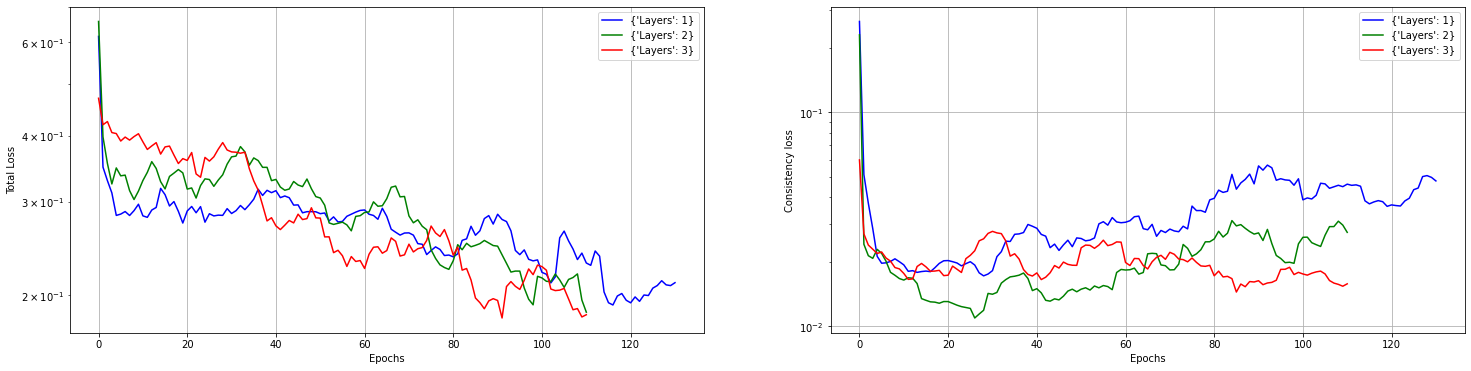

Generating 200 / 200 samples before starting training


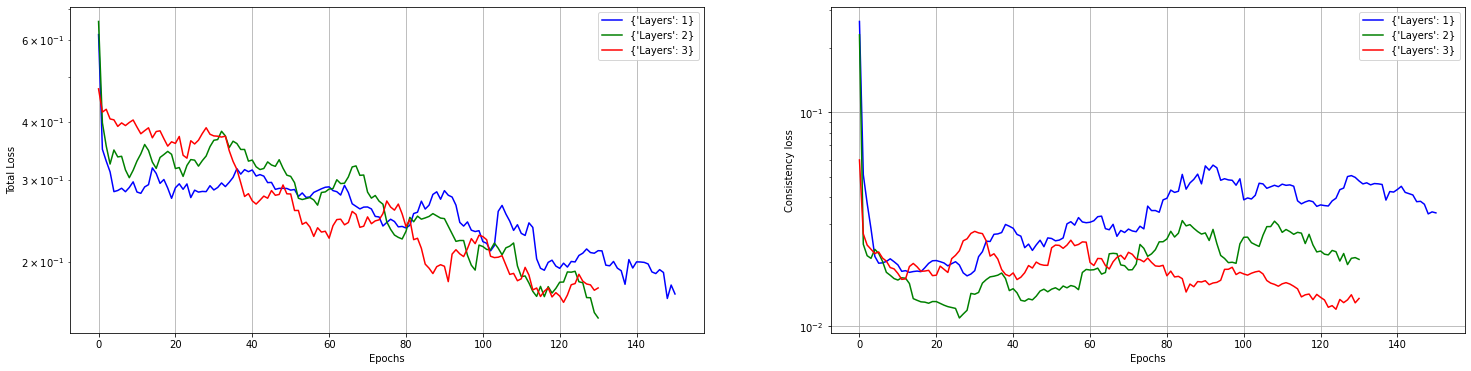

Generating 201 / 200 samples before starting training


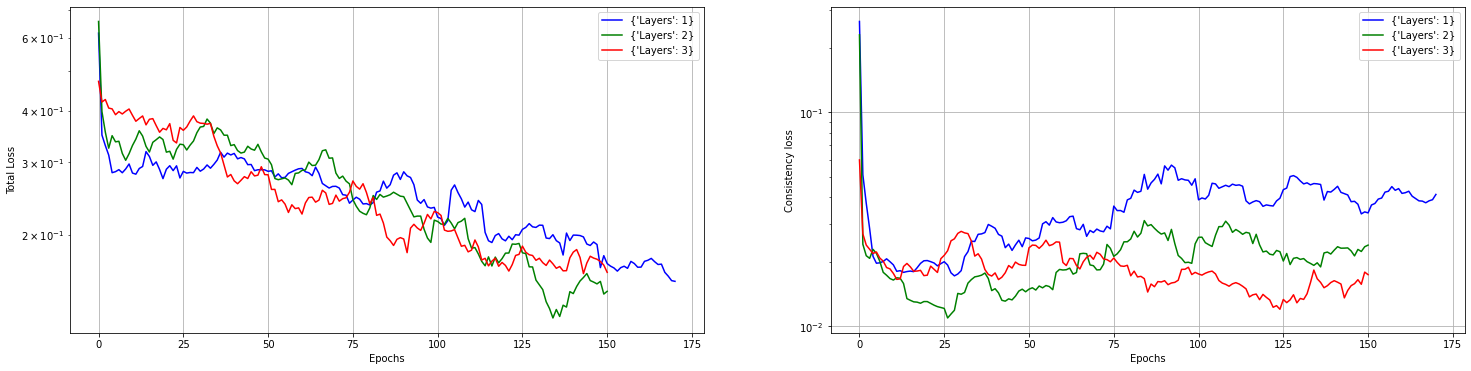

Generating 200 / 200 samples before starting training


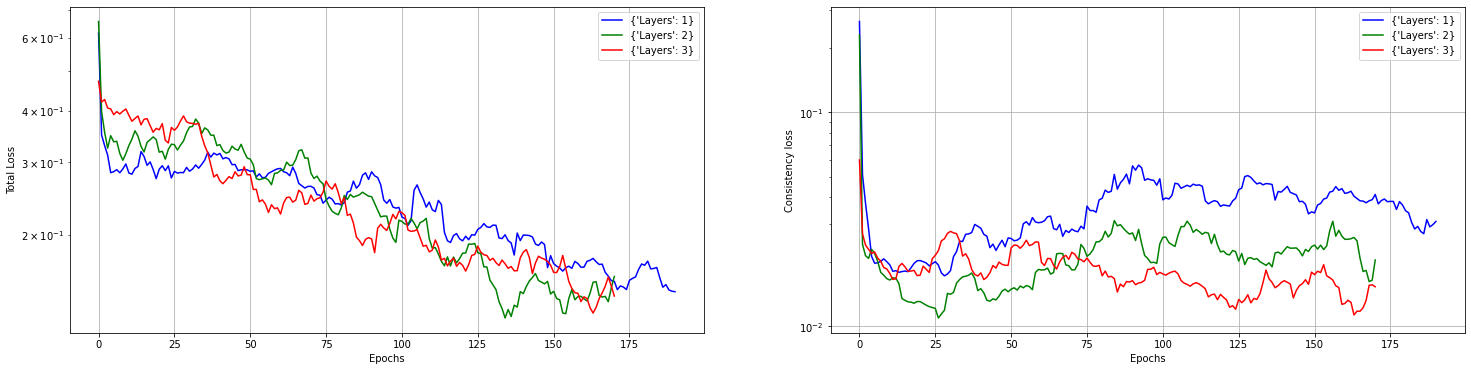

Generating 200 / 200 samples before starting training


KeyboardInterrupt: ignored

In [47]:
def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(models):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = (cycler(color=list('bgrcmyk')))
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    for i, model in enumerate(models):
        ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Total Loss")
        ax1.set_yscale("log")
        ax1.legend()

        ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Consistency loss")
        ax2.set_yscale("log")
        ax2.legend()

    ax1.grid(True)
    ax2.grid(True)
    plt.show()

while True:
    with generator:
        for model in models:
            h = model.fit(generator, epochs=20, steps_per_epoch=100, verbose=0)
            save_progress(model, h)
        plot_progress(models)
        



In [25]:
for model in models:
    print(model.specs)
    model.summary()


{'Layers': 1}
Model: "lode_star_base_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 29, 29, 4)         19940     
                                                                 
Total params: 19,940
Trainable params: 19,940
Non-trainable params: 0
_________________________________________________________________
{'Layers': 2}
Model: "lode_star_base_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 27, 27, 4)         56868     
                                                                 
Total params: 56,868
Trainable params: 56,868
Non-trainable params: 0
_________________________________________________________________
{'Layers': 3}
Model: "lode_star_base_model_8"
______________________________________________________________

In [26]:
def get_propagation_matrix(shape, to_z, pixel_size, wavelength):

    k = 2 * np.pi / wavelength
    yr, xr, *_ = shape

    x = 2 * np.pi / pixel_size * np.arange(-(xr / 2 - 1 / 2), (xr / 2 + 1 / 2), 1) / xr
    y = 2 * np.pi / pixel_size * np.arange(-(yr / 2 - 1 / 2), (yr / 2 + 1 / 2), 1) / yr
    KXk, KYk = np.meshgrid(x, y)

    K = np.real(
        np.sqrt(np.array(1 - (KXk / k) ** 2 - (KYk / k) ** 2, dtype=np.complex64))
    )
    C = np.fft.fftshift(((KXk / k) ** 2 + (KYk / k) ** 2 < 1) * 1.0)

    return C * np.fft.fftshift(np.exp(k * 1j * to_z * (K - 1)))

def fourier_transform(image, padding=32):
    im = np.pad(image, ((padding, padding), (padding, padding)), mode="symmetric")
    return np.fft.fft2(im)

def inverse_fourier_transform(image, padding=32):
    im = np.fft.ifft2(image)
    return im[padding:-padding, padding:-padding]

def fourier_transform_transformation(image, Tz, Tzinv, i):
    if i < 0:
        image *= Tzinv ** np.abs(i)
    else:
        image *= Tz ** i
    return image

def propagate(image, z):
    """Re-propagate the images using PAS"""
    ft_image = fourier_transform(image[:,:,0])
    prop_ft_image = fourier_transform_transformation(ft_image, crop_propagation_backward, crop_propagation_forward, z)
    return np.expand_dims(inverse_fourier_transform(prop_ft_image),axis=-1)

{'Layers': 1}
PROPAGERADE BILDER


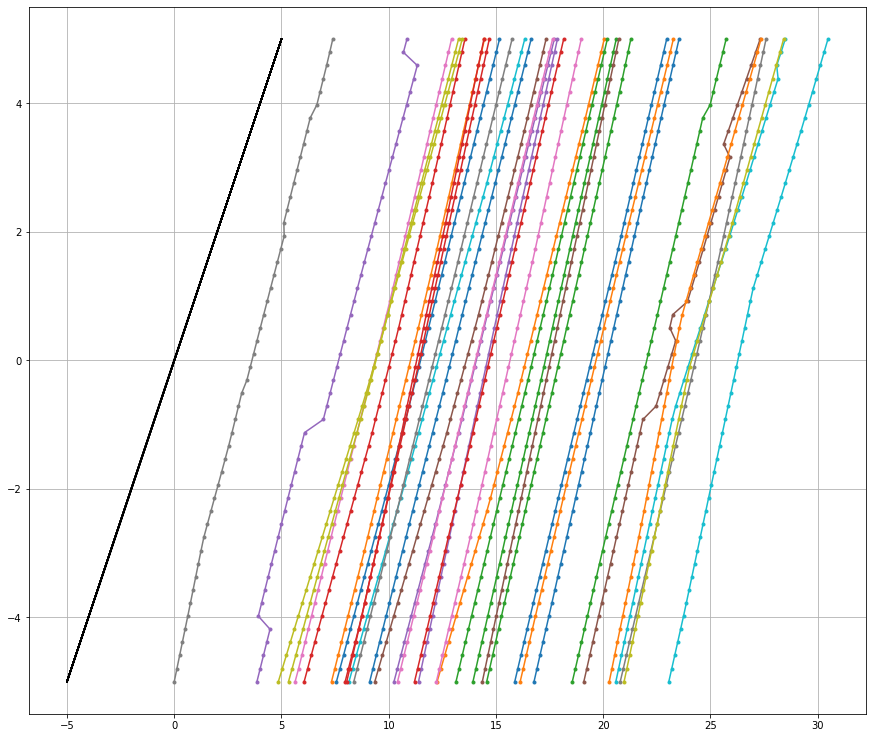

STD: 5.618
{'Layers': 2}
PROPAGERADE BILDER


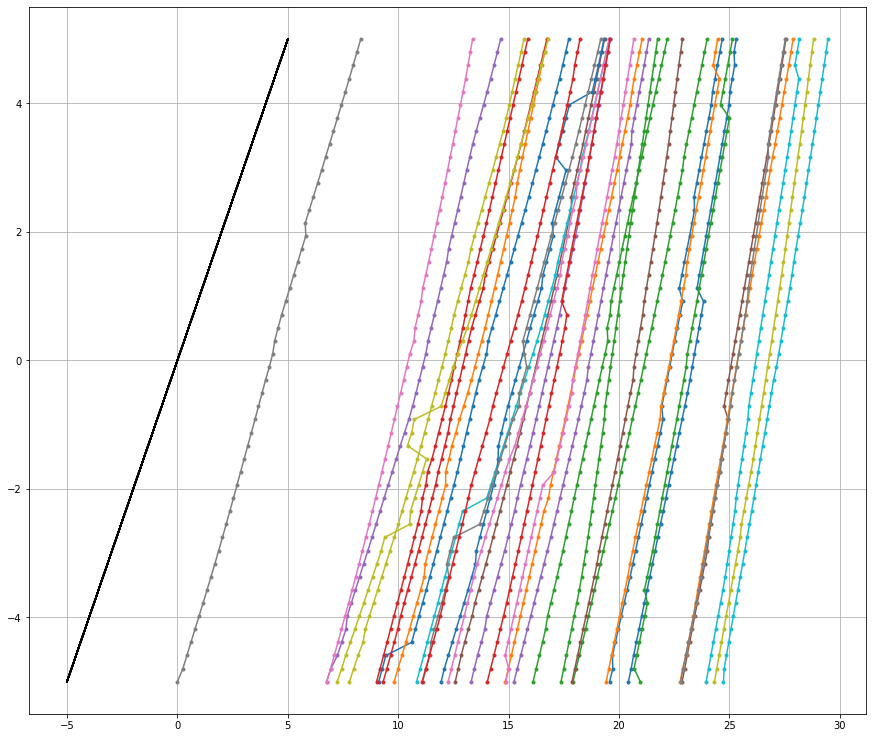

STD: 5.531
{'Layers': 3}
PROPAGERADE BILDER


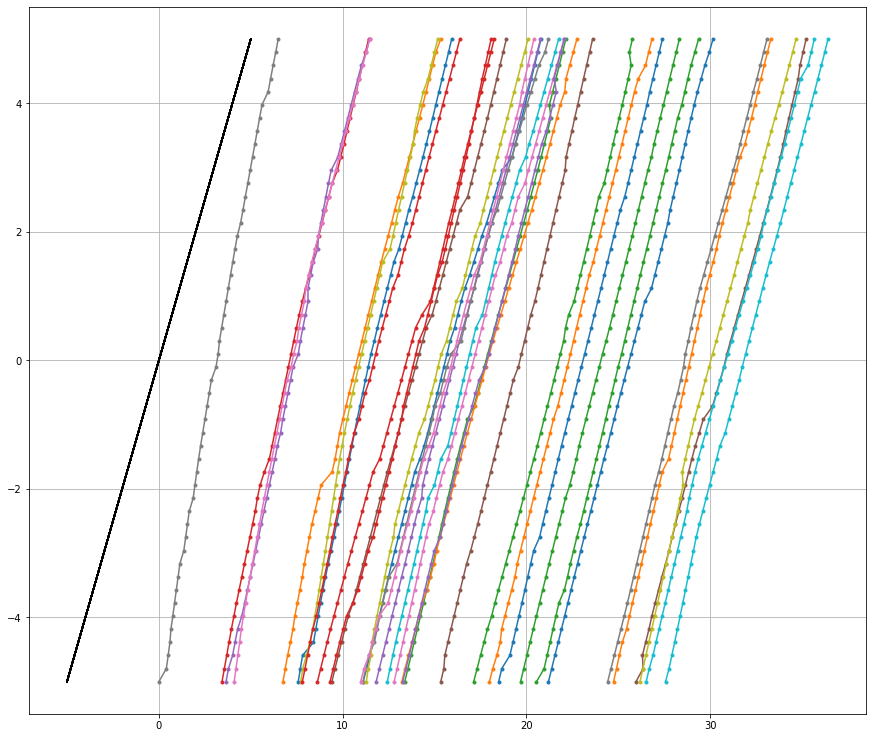

STD: 7.524


In [48]:
cc = (cycler(color=list('bgrcmyk')))

def predict_on_stack(model, val_stack):
    """returns a numpy tensor containing propagated distance as well as the prediction, for ever propagation distance and every image images"""
    try:
        dets = np.array(model.predict_and_detect(val_stack, mode="ratio"))
    except ValueError as E:
        dets = np.expand_dims(np.zeros((val_stack.shape[0],3)), axis=0)
        print(E)
    dets = reshape_dets(dets)
    dets *= multfact
    #dets[:,2] = dets[:,2] - np.mean(dets[:,2])
    return dets

def reshape_dets(dets):
    """Removes all particles but the one closest to the center. If no particles are detected, sets the value to 0."""
    out = []
    for coords in dets:
        if coords.shape != (0, 3):
            x, y = IMAGE_SIZE//2, IMAGE_SIZE//2
            idx = np.argmin(np.array(coords[:,:2]- np.array((x, y))), axis=0)[0]
            out.append(coords[idx,:])
        else:
            out.append([0,0,0])
    return np.array(out)

def create_validation_stack(images, z_list):
    """"""
    output = []
    for i in range(images.shape[0]):
        image = images[i,:,:,:]
        stack = []
        for z in z_list:
            stack.append(propagate(image, z))
        output.append(stack)
    return np.stack((np.real(output), np.imag(output)), axis=-1)[:,:,:,:,0,:]

def plot_preds(val_stack):
    for particle_id in range(from_id, from_id+num_samples):
        dets = model.predict_and_detect(val_stack[:,:,:,:], mode="ratio"), 
        plt.figure(figsize=(10, 10))
        plt.imshow(np.abs(val_stack[stack_id,:,:,0]+1j*val_stack[stack_id,:,:,1]), cmap="bone")
        dets = np.squeeze(np.array(dets))
        print(dets)
        plt.scatter(dets[stack_id,1], dets[stack_id,0], s=200, facecolor="none", linewidths=3, edgecolors="g")
        plt.show()
        
        dets[:,2] *= multfact
        #dets[:,2] -= np.mean(dets[:,2])
        #[print(d) for d in dets]

def evaluate_model(model, val_stack, prop_range):
    accs = []
    for i in range(num_samples):
        accs.append(predict_on_stack(model, val_stack[from_id+i])[:,2])
    accs = np.array(accs)
    accs -= np.min(accs)

    stds = []
    fig, ax = plt.subplots(1,1, figsize=(15,13))
    for i in range(accs.shape[0]):
        ax.plot(prop_range, prop_range, 'k')
        ax.plot(accs[i,:].flatten(), prop_range, '.-')
        ax.grid(True)
        stds.append(np.std(accs[i,:].flatten() - prop_range))
    plt.show()
    print(f"STD: {np.std((accs-prop_range).flatten()):.3f}", )

#model = models[-3]
for model in models:
    prop_range = np.linspace(-5, 5, 50) #np.random.randn(70)
    from_id = 0
    num_samples = len(particles_positions[particle_id][:,0])-training_set_size
    stack_id = len(prop_range)//2
    multfact = -1
    print(model.specs)
    print("PROPAGERADE BILDER")
    val_stack = create_validation_stack(validation_set, prop_range)
    evaluate_model(model, val_stack, prop_range)

    timeseries_images = np.stack( (np.real(validation_set[:,:,:,0]), np.imag(validation_set[:,:,:,0])), axis=-1)
    corrections = predict_on_stack(model, timeseries_images)
    x_lode, y_lode, z_lode = corrections[:,0], corrections[:,1], corrections[:,2]
    x_matlab, y_matlab, z_matlab = particles_positions[particle_id][training_set_size:,0], particles_positions[particle_id][training_set_size:,1], particles_positions[particle_id][training_set_size:,2]
    z_lode = z_lode*multfact
    z_lode = z_lode - np.mean(z_lode)


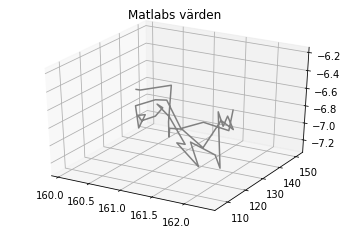

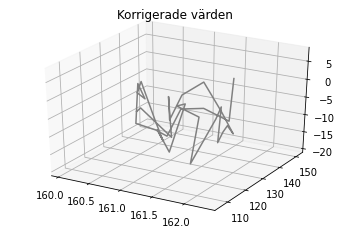

Matlab!


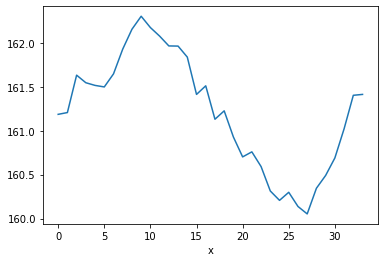

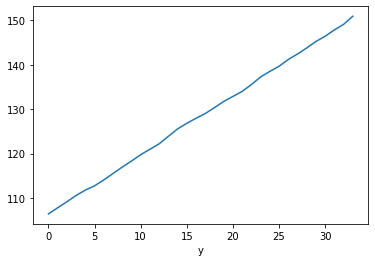

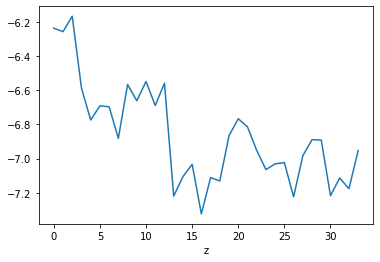

LodeSTAR & Matlab!


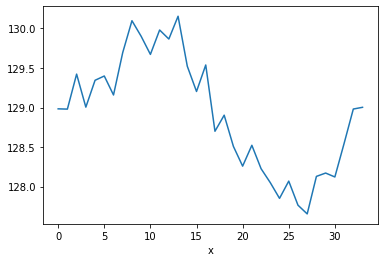

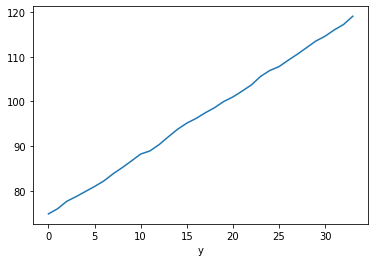

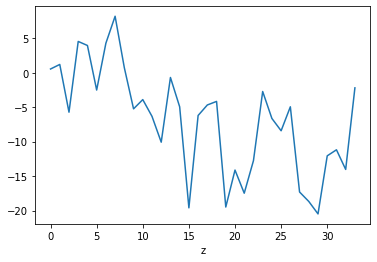

In [50]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab, 'gray')
ax.set_title("Matlabs värden")
plt.show()

ax = plt.axes(projection='3d')
ax.plot3D(x_matlab, y_matlab, z_matlab+z_lode, 'gray')
ax.set_title("Korrigerade värden")
plt.show()

print("Matlab!")
plt.plot(list(range(len(x_matlab))), x_matlab)
plt.xlabel("x")
plt.show()
plt.plot(list(range(len(y_matlab))), y_matlab)
plt.xlabel("y")
plt.show()
plt.plot(list(range(len(z_matlab))), z_matlab)
plt.xlabel("z")
plt.show()

#print("LodeSTAR!")
#plt.plot(list(range(len(x_lode))), x_lode)
#plt.xlabel("x")
#plt.show()
#plt.plot(list(range(len(y_lode))), y_lode)
#plt.xlabel("y")
#plt.show()
#plt.plot(list(range(len(z_corrections))), z_corrections)
#plt.xlabel("z")
#plt.show()

print("LodeSTAR & Matlab!")
plt.plot(list(range(len(x_lode))), x_lode+x_matlab)
plt.xlabel("x")
plt.show()
plt.plot(list(range(len(y_lode))), y_lode+y_matlab)
plt.xlabel("y")
plt.show()
plt.plot(list(range(len(z_lode))), z_lode+z_matlab)
plt.xlabel("z")
plt.show()

#print(f"Sigma_z^2 matlab: {sigma_square_old:.2f}\nSigma_z^2 korrigerad med nätverket: {sigma_square_new:.2f}")
#https://journals.aps.org/pre/pdf/10.1103/PhysRevE.89.022726

0.018673365000429796


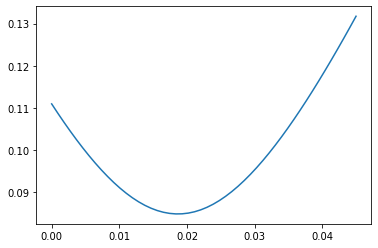

0.0847514658272118


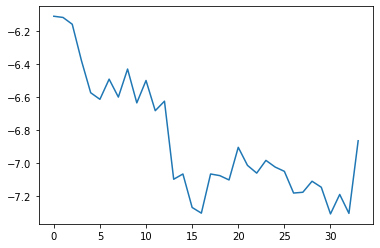

0.11092092012255088


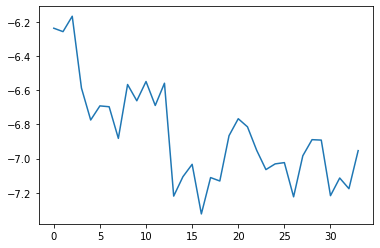

In [51]:
def sigma_x(x):
    arr = x_matlab + x_lode*x
    return calc_sigma(arr)

def sigma_y(x):
    arr = y_matlab + y_lode*x
    return calc_sigma(arr)

def sigma_z(x):
    arr = z_matlab + z_lode*x
    return calc_sigma(arr)

def calc_sigma(arr):
    sigma2 = np.abs(np.mean(
        np.multiply(
            np.diff(arr[:-1]), 
            np.diff(arr[1:])
            )
    ))
    return np.sqrt(sigma2)

"z seems to vary too much, multiplicative factor?"
from scipy.optimize import minimize
z_mult = minimize(sigma_z, [1], method="Powell").x

print(z_mult)
z_new = z_matlab+z_mult*z_lode

xarr = np.linspace(0, 0.045)
plt.plot(xarr, [sigma_z(x) for x in xarr])
plt.show()

print(calc_sigma(z_new))
plt.plot(z_new)
plt.show()

print(calc_sigma(z_matlab))
plt.plot(z_matlab)
plt.show()

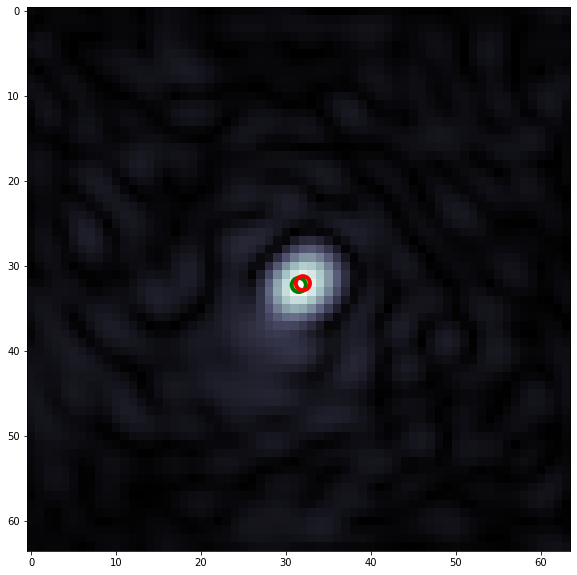

0


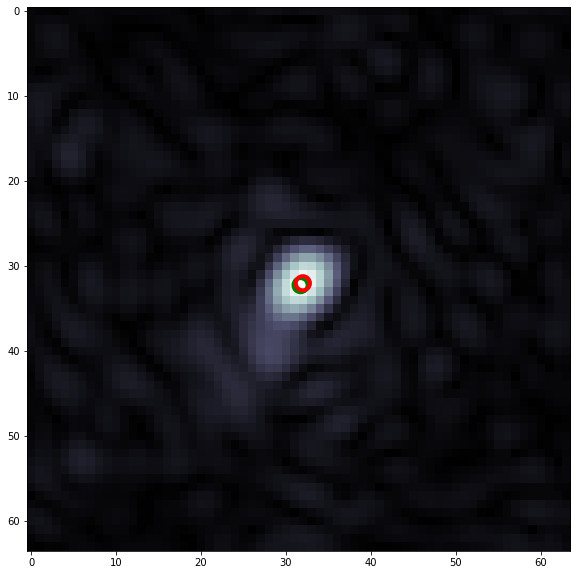

1


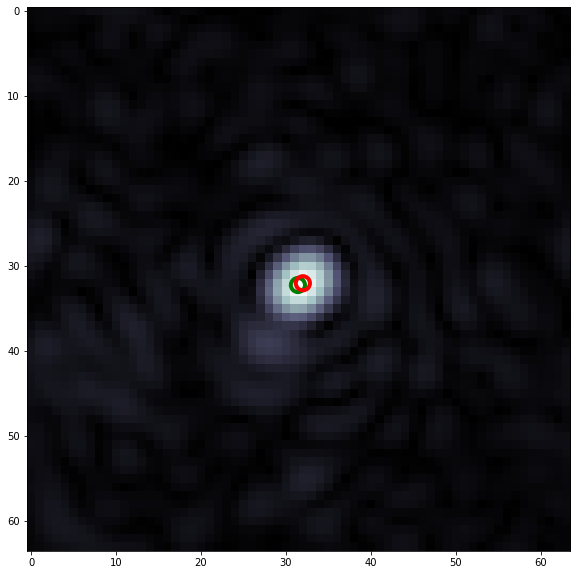

2


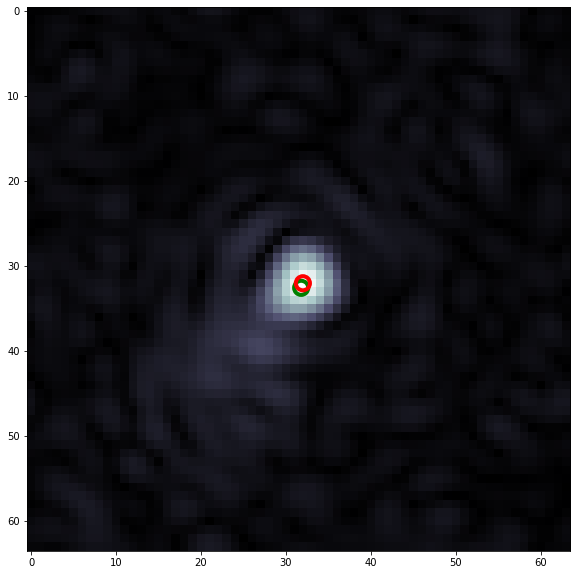

3


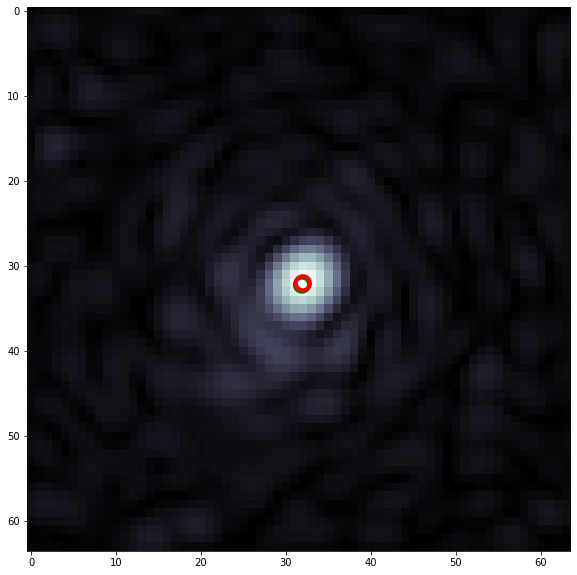

4


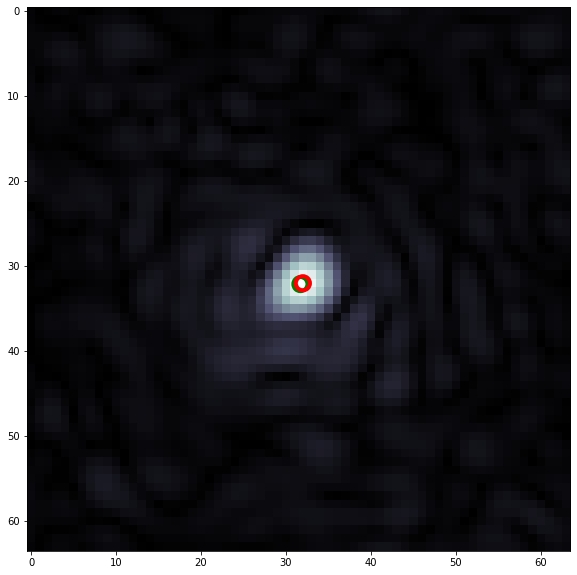

5


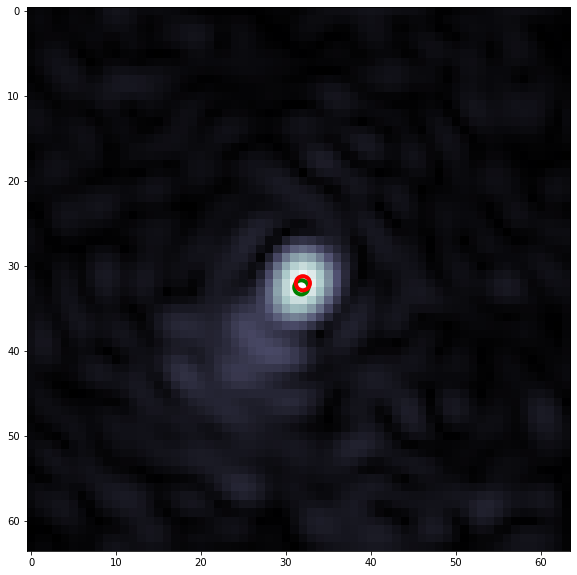

6


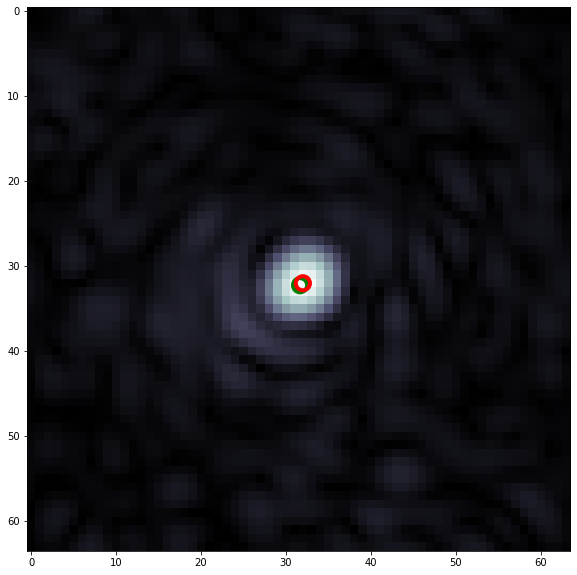

7


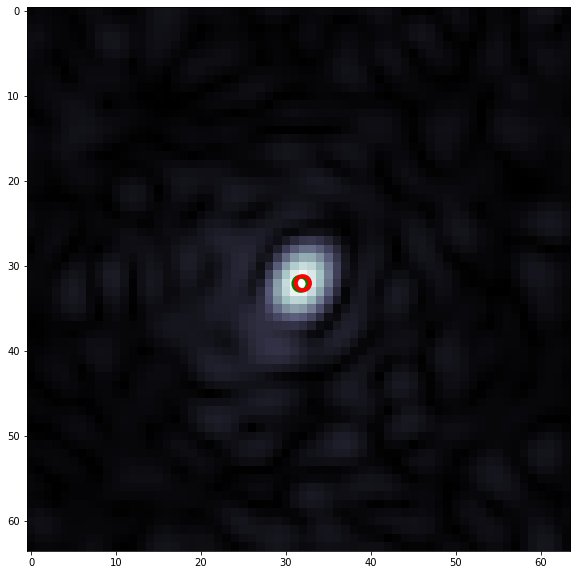

8


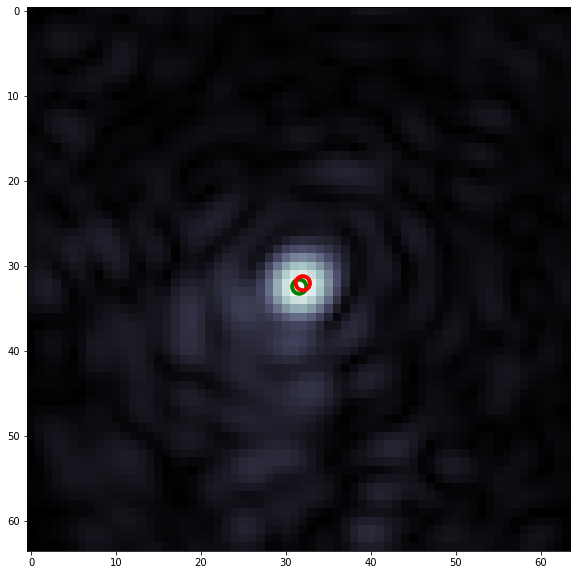

9


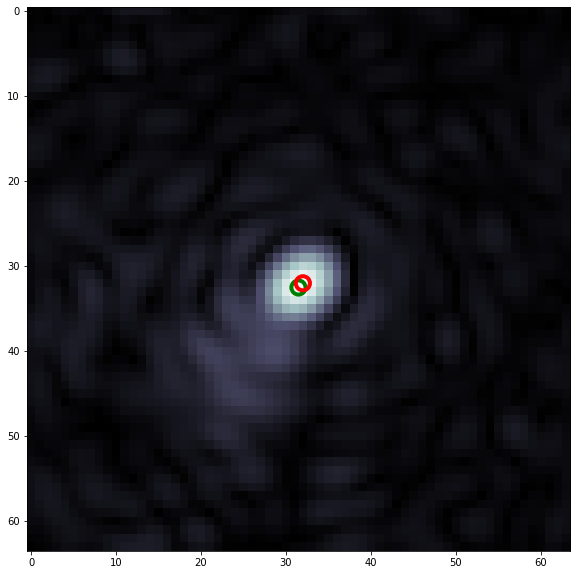

10


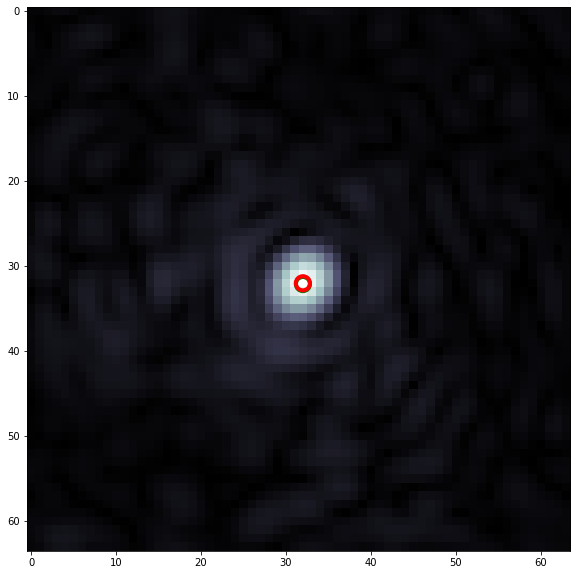

11


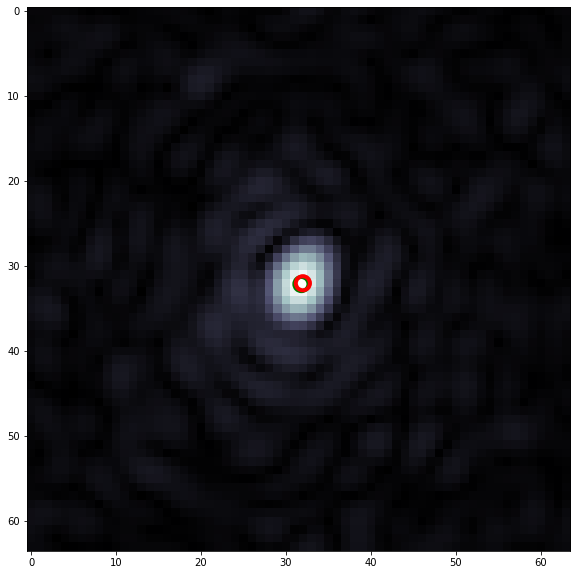

12


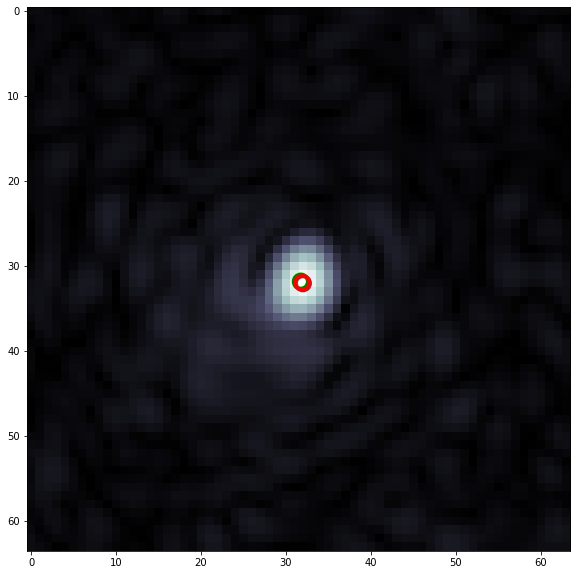

13


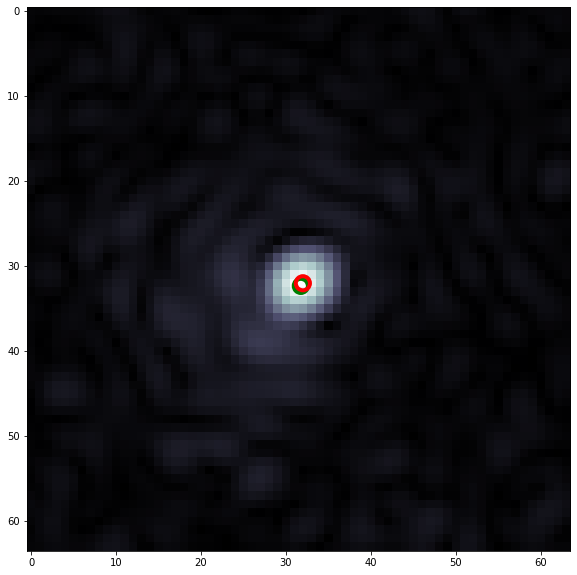

14


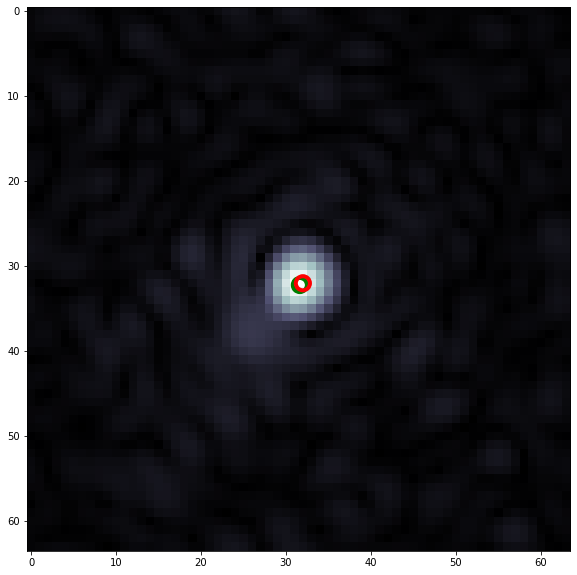

15


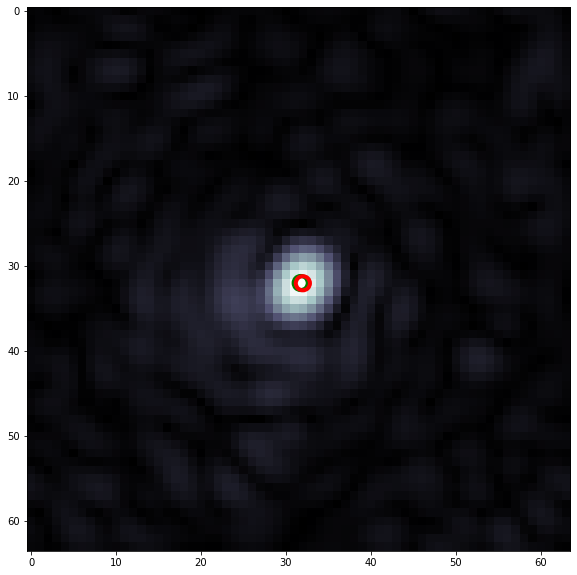

16


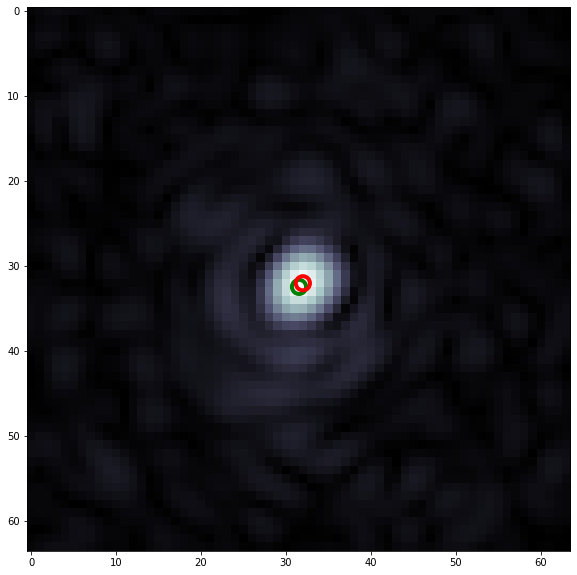

17


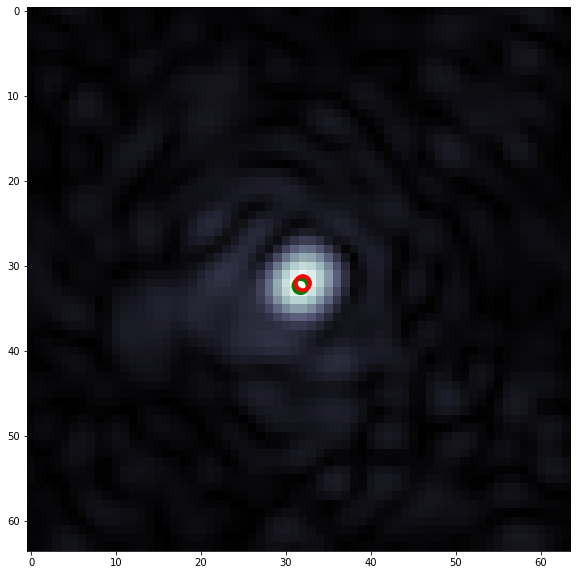

18


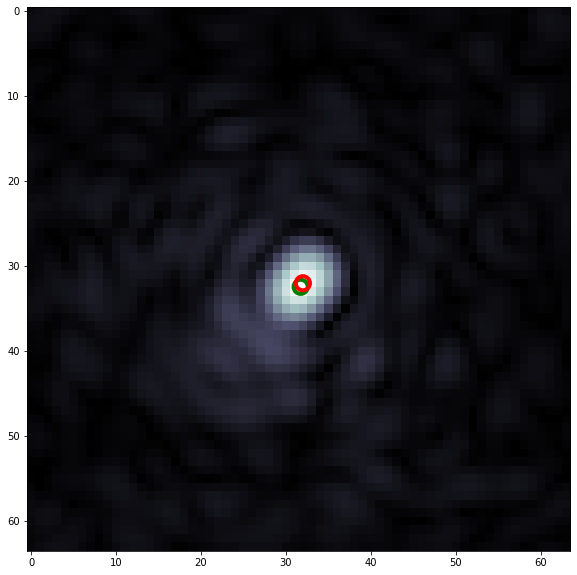

19


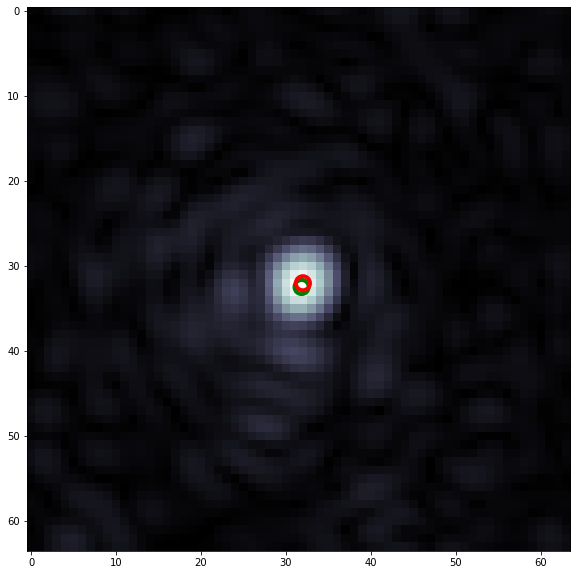

20


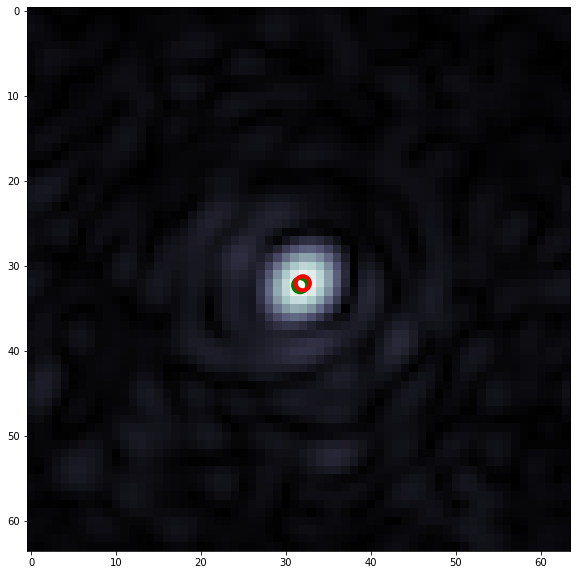

21


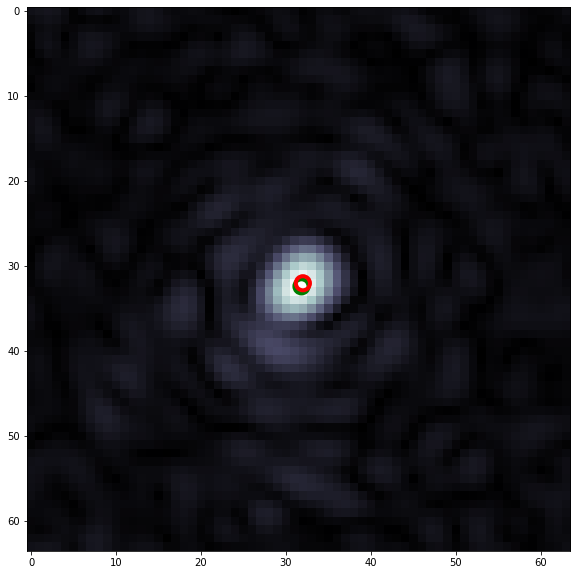

22


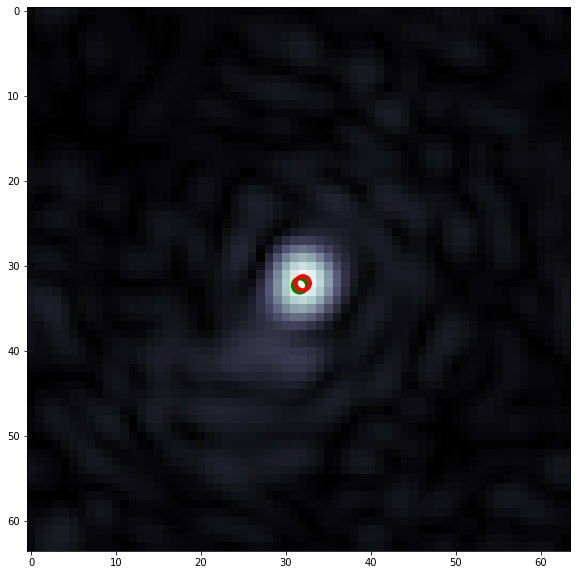

23


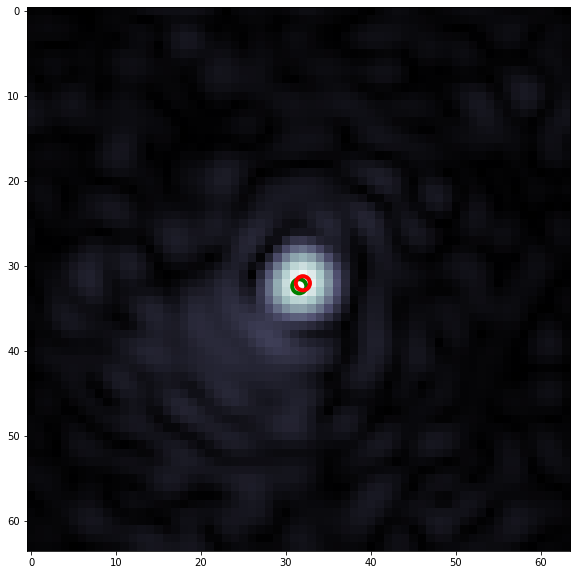

24


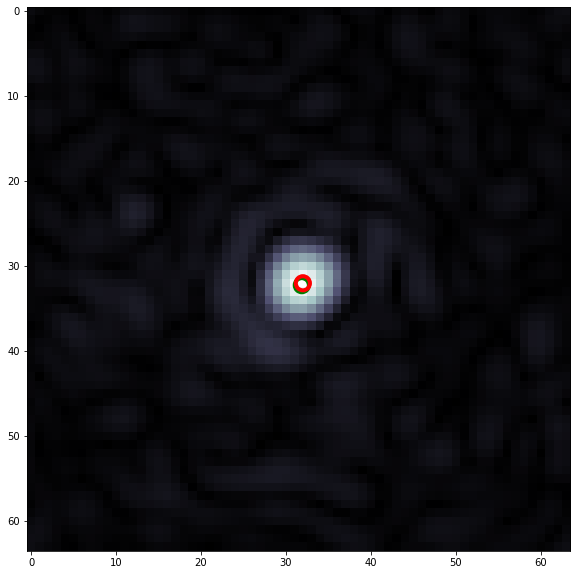

25


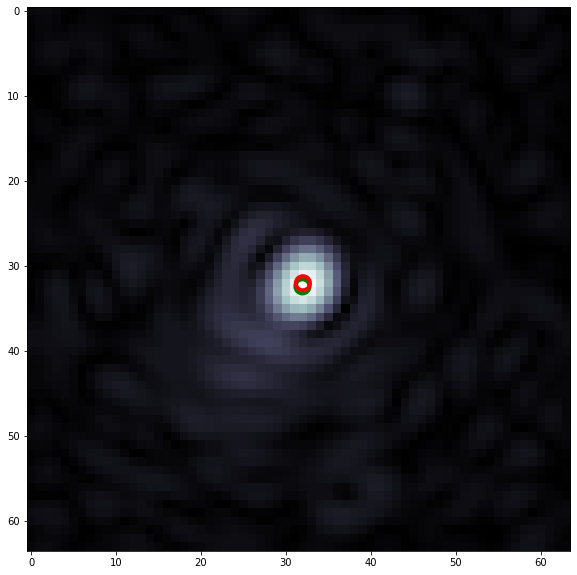

26


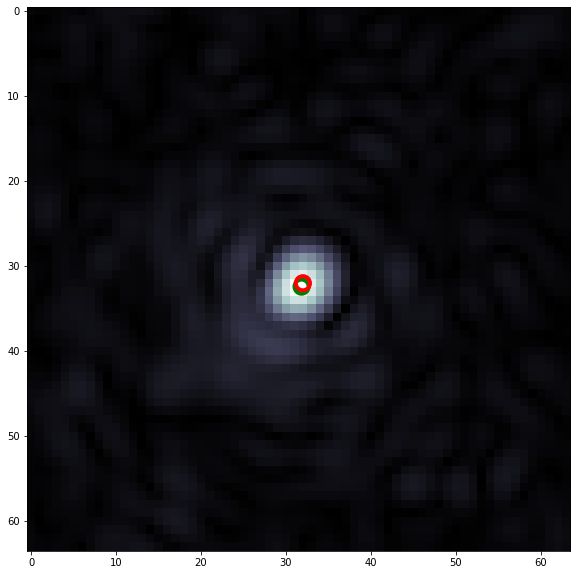

27


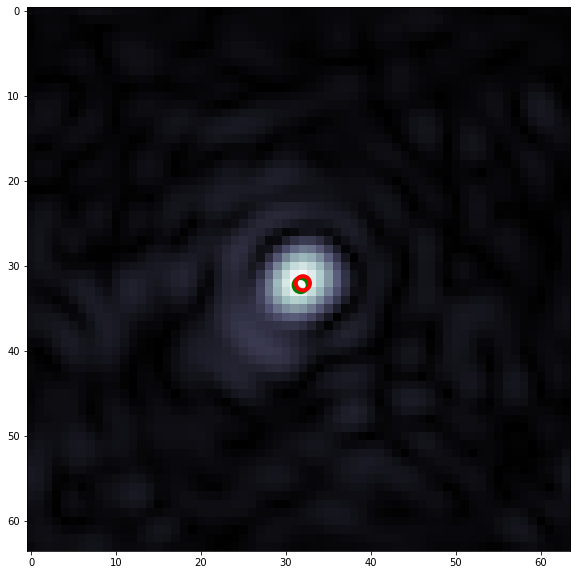

28


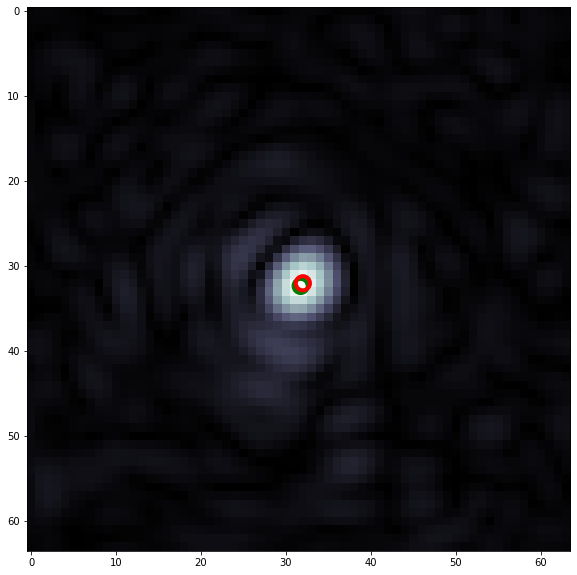

29


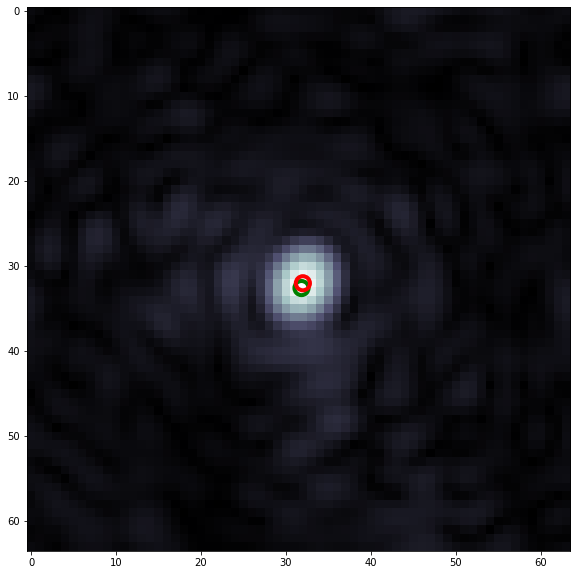

30


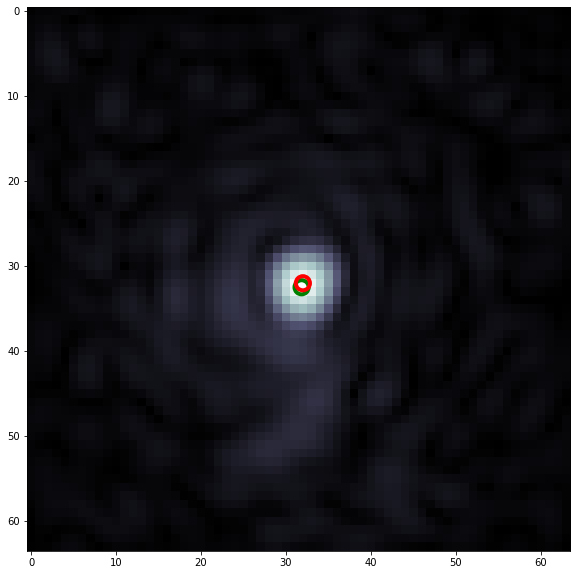

31


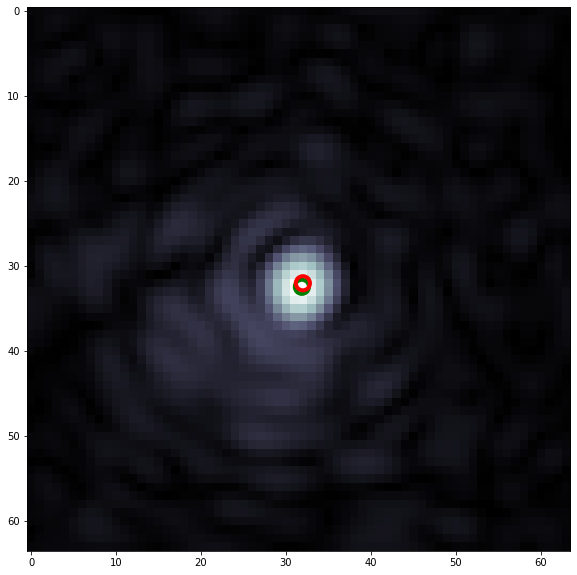

32


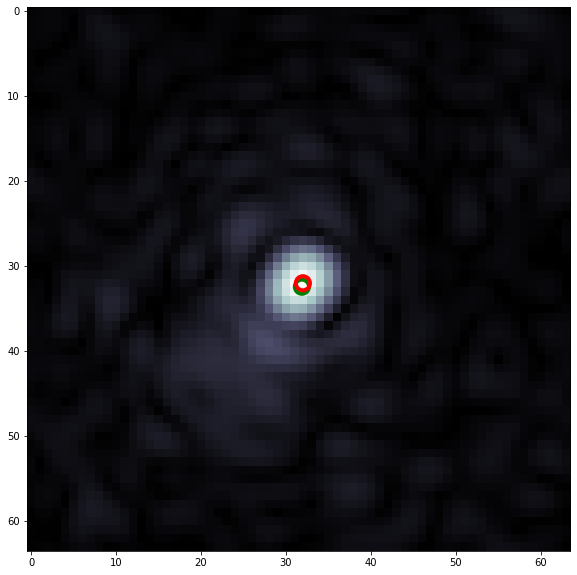

33


(array([32.20284 , 32.226345, 32.209175, 32.540768, 32.17065 , 32.0992  ,
        32.487724, 32.23284 , 32.05597 , 32.40148 , 32.50118 , 32.095356,
        32.097794, 31.807903, 32.314682, 32.209763, 31.972525, 32.4305  ,
        32.322575, 32.419746, 32.443302, 32.23692 , 32.365715, 32.264633,
        32.356598, 32.23025 , 32.37335 , 32.399025, 32.216305, 32.319717,
        32.56819 , 32.47611 , 32.421856, 32.41005 ], dtype=float32),
 array([31.518866, 31.727577, 31.41687 , 31.801174, 31.886911, 31.711082,
        31.815647, 31.669107, 31.721893, 31.574423, 31.481226, 32.0072  ,
        31.827526, 31.762512, 31.758509, 31.643257, 31.741417, 31.54554 ,
        31.734406, 31.739082, 31.851921, 31.679655, 31.835634, 31.64809 ,
        31.573696, 31.873219, 31.951351, 31.84747 , 31.7398  , 31.7373  ,
        31.837301, 31.8484  , 31.884783, 31.887133], dtype=float32),
 array([-23.97958  , -24.659641 , -17.642084 , -28.326778 , -27.928318 ,
        -21.3808   , -28.179815 , -32.278393 , -2

In [52]:
def compare_lode_matlab(val_stack):
    for particle_id in range(from_id, from_id+num_samples):
        dets = model.predict_and_detect(val_stack[:,:,:,:], mode="ratio"), 
        plt.figure(figsize=(10, 10))
        plt.imshow(np.abs(val_stack[particle_id,:,:,0]+1j*val_stack[particle_id,:,:,1]), cmap="bone")
        dets = np.squeeze(np.array(dets))
        plt.scatter(dets[particle_id,1], dets[particle_id,0], s=200, facecolor="none", linewidths=4, edgecolors="g")
        plt.scatter(32, 32, s=200, facecolor="none", linewidths=4, edgecolors="r")
        plt.show()
        print(particle_id)
        dets[:,2] *= multfact
    return (dets[:,0], dets[:,1], dets[:,2])

compare_lode_matlab(timeseries_images)
